<a href="https://colab.research.google.com/github/nainye/nlp_practice/blob/main/word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한글폰트 설치

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

# Install

In [2]:
!pip install sentencepiece

# Evn

In [3]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [4]:
from sklearn.decomposition import PCA

In [5]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [6]:
!nvidia-smi

Sat Jan 30 14:36:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Word2Vec (Skip-gram)


## 모델링

In [7]:
# 입력 문장
sentences = """나는 오늘 기분이 좋아
나는 오늘 우울해"""

# 문장을 띄어쓰기 단위로 분할
words = sentences.split()

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

{'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5}

In [8]:
# 입력(c), 출력(o) 정의
inputs = np.array([word_to_id['나는']])
labels = np.array([word_to_id['기분이']])
inputs, labels

(array([2]), array([4]))

In [9]:
# center word embedding
V = tf.keras.layers.Embedding(len(word_to_id), 4) # 4로 설정
v = V(inputs)
v

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.02788493,  0.00853021,  0.02688133, -0.00167429]],
      dtype=float32)>

In [10]:
# weight of center matrix
V.get_weights()[0].shape, V.get_weights()

((7, 4), [array([[ 0.00380393, -0.01353813,  0.00816301, -0.02561716],
         [-0.00696643,  0.04061912,  0.00072207, -0.01411822],
         [ 0.02788493,  0.00853021,  0.02688133, -0.00167429],
         [ 0.00873896, -0.04772998, -0.00643448,  0.04782395],
         [ 0.04810704, -0.03535189,  0.04945729,  0.02813626],
         [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371],
         [-0.00963336, -0.01013004,  0.01826939,  0.02741292]],
        dtype=float32)])

In [11]:
# outer word embedding transpose
U = tf.keras.layers.Dense(len(word_to_id), use_bias=False)

In [12]:
vu = U(v)
vu

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[ 3.5610533e-04,  2.1611415e-05,  1.2270883e-02,  3.7757820e-03,
         3.2251843e-03, -2.6024913e-02,  3.1729113e-02]], dtype=float32)>

In [13]:
# weight of outer matrix transpose
U.get_weights()[0].shape, U.get_weights()[0]

((4, 7),
 array([[-0.2579534 , -0.5336746 ,  0.21868336, -0.28948402, -0.24111664,
         -0.54625964,  0.3039828 ],
        [ 0.32288855, -0.16226333,  0.453376  , -0.03352547,  0.01449347,
         -0.43671843,  0.44746655],
        [ 0.20950413,  0.6314514 ,  0.12539876,  0.4274159 ,  0.32529944,
         -0.26464936,  0.69570595],
        [ 0.49987453,  0.41033334,  0.6363074 , -0.3849371 , -0.6454024 ,
         -0.02802688, -0.43844774]], dtype=float32))

In [14]:
WU = U.get_weights()[0]
np.dot(v, WU[:,1])

array([2.1612272e-05], dtype=float32)

In [15]:
# exp(uv) / sum(exp(uv))
vu_prob = tf.nn.softmax(vu)
vu_prob

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.14237338, 0.14232577, 0.14407988, 0.1428611 , 0.14278245,
        0.13866654, 0.14691088]], dtype=float32)>

In [16]:
# outer word embedding transpose & softmax
U = tf.keras.layers.Dense(len(word_to_id), use_bias=False, activation=tf.nn.softmax)
vu_prob = U(v)
vu_prob

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.14448835, 0.14035739, 0.14572215, 0.14384103, 0.14423797,
        0.13938786, 0.14196528]], dtype=float32)>

In [17]:
# weight of outer matrix transpose
U.get_weights()[0].shape, U.get_weights()[0]

((4, 7),
 array([[ 0.14403158, -0.29078478,  0.73512465,  0.45532328, -0.1224649 ,
         -0.703691  ,  0.16324377],
        [-0.7000179 ,  0.7047326 , -0.286127  ,  0.34271616,  0.15090996,
         -0.13226604, -0.44013816],
        [ 0.3430454 , -0.6646802 , -0.06911588, -0.45315602,  0.33291012,
         -0.280751  , -0.40085226],
        [-0.4404183 ,  0.62021023, -0.1831069 , -0.04489857,  0.32958573,
         -0.21682096, -0.21829158]], dtype=float32))

In [18]:
# label one hot
vu_label = tf.one_hot(labels, len(word_to_id))
vu_label

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=array([[0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>

In [19]:
# cross entroyp loss
loss = - vu_label * tf.math.log(vu_prob)
loss

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[0.       , 0.       , 0.       , 0.       , 1.9362909, 0.       ,
        0.       ]], dtype=float32)>

In [20]:
# sparse_categorical_crossentropy
tf.keras.losses.sparse_categorical_crossentropy(labels, vu_prob)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.9362909], dtype=float32)>

In [21]:
def build_model(n_vocab, d_model):
    """
    skim gram 학습 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    """
    tokens = tf.keras.layers.Input(shape=(1,))

    ###########################################
    # center word vector
    V = tf.keras.layers.Embedding(n_vocab, d_model)  # (n_vocab, d_model)
    v = V(tokens)  # (bs, 1, d_model)

    # 단어 예측 (activation=tf.nn.softmax)
    U = tf.keras.layers.Dense(n_vocab, use_bias=False, activation=tf.nn.softmax)  # (d_model, n_vocab)
    vu_prob = U(v)  # (bs, 1, n_vocab)
    ###########################################

    model = tf.keras.Model(inputs=tokens, outputs=vu_prob)
    return model, V # V는 보통 리턴하지 않지만, embedding 출력을 위한 것

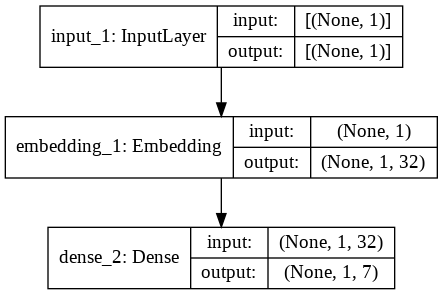

In [22]:
# 모델 생성
model, V = build_model(len(word_to_id), 32)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

## 데이터

In [23]:
# 학습할 말뭉치
text = """수학은 수식이 복잡해서 어렵다
수학은 공식이 많아서 어렵다
수학은 수식이 이해되면 쉽다
수학은 공식이 능통하면 쉽다
영어는 단어가 많아서 어렵다
영어는 듣기가 복잡해서 어렵다
영어는 단어가 이해되면 쉽다
영어는 듣기가 능통하면 쉽다
국어는 지문이 복잡해서 어렵다
국어는 한문이 많아서 어렵다
국어는 지문이 이해되면 쉽다
국어는 한문이 능통하면 쉽다"""

## Vocabulary

In [24]:
# 띄어쓰기 기준 단어 목록
words = list(dict.fromkeys(text.split()))
words

['수학은',
 '수식이',
 '복잡해서',
 '어렵다',
 '공식이',
 '많아서',
 '이해되면',
 '쉽다',
 '능통하면',
 '영어는',
 '단어가',
 '듣기가',
 '국어는',
 '지문이',
 '한문이']

In [25]:
# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)
word_to_id

{'[PAD]': 0,
 '[UNK]': 1,
 '공식이': 6,
 '국어는': 14,
 '능통하면': 10,
 '단어가': 12,
 '듣기가': 13,
 '많아서': 7,
 '복잡해서': 4,
 '수식이': 3,
 '수학은': 2,
 '쉽다': 9,
 '어렵다': 5,
 '영어는': 11,
 '이해되면': 8,
 '지문이': 15,
 '한문이': 16}

In [26]:
# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}
id_to_word

{0: '[PAD]',
 1: '[UNK]',
 2: '수학은',
 3: '수식이',
 4: '복잡해서',
 5: '어렵다',
 6: '공식이',
 7: '많아서',
 8: '이해되면',
 9: '쉽다',
 10: '능통하면',
 11: '영어는',
 12: '단어가',
 13: '듣기가',
 14: '국어는',
 15: '지문이',
 16: '한문이'}

## 학습용 데이터 생성

In [27]:
# 줄바꿈 단위로 문장 분리
sentences = text.split("\n")
sentences

['수학은 수식이 복잡해서 어렵다',
 '수학은 공식이 많아서 어렵다',
 '수학은 수식이 이해되면 쉽다',
 '수학은 공식이 능통하면 쉽다',
 '영어는 단어가 많아서 어렵다',
 '영어는 듣기가 복잡해서 어렵다',
 '영어는 단어가 이해되면 쉽다',
 '영어는 듣기가 능통하면 쉽다',
 '국어는 지문이 복잡해서 어렵다',
 '국어는 한문이 많아서 어렵다',
 '국어는 지문이 이해되면 쉽다',
 '국어는 한문이 능통하면 쉽다']

In [28]:
# 띄어쓰기 단위로 단어 분리
tokens = []
for sentence in sentences:
    tokens.append(sentence.split())
tokens

[['수학은', '수식이', '복잡해서', '어렵다'],
 ['수학은', '공식이', '많아서', '어렵다'],
 ['수학은', '수식이', '이해되면', '쉽다'],
 ['수학은', '공식이', '능통하면', '쉽다'],
 ['영어는', '단어가', '많아서', '어렵다'],
 ['영어는', '듣기가', '복잡해서', '어렵다'],
 ['영어는', '단어가', '이해되면', '쉽다'],
 ['영어는', '듣기가', '능통하면', '쉽다'],
 ['국어는', '지문이', '복잡해서', '어렵다'],
 ['국어는', '한문이', '많아서', '어렵다'],
 ['국어는', '지문이', '이해되면', '쉽다'],
 ['국어는', '한문이', '능통하면', '쉽다']]

In [29]:
# center-outer 생성
window_size = 2
word_pairs = []
for line_token in tokens:
    print(line_token)
    for i in range(len(line_token)):
        #####################################
        o_1 = max(0, i - window_size)
        o_2 = min(len(line_token) - 1, i + window_size)
        c = line_token[i]
        o = [line_token[j] for j in range(o_1, o_2 + 1) if j != i]
        print(i, '/', o_1, '/', o_2, '/', c, '/', o)
        word_pairs.append({"c": c, "o": o})
        #####################################
print(len(word_pairs))
word_pairs

['수학은', '수식이', '복잡해서', '어렵다']
0 / 0 / 2 / 수학은 / ['수식이', '복잡해서']
1 / 0 / 3 / 수식이 / ['수학은', '복잡해서', '어렵다']
2 / 0 / 3 / 복잡해서 / ['수학은', '수식이', '어렵다']
3 / 1 / 3 / 어렵다 / ['수식이', '복잡해서']
['수학은', '공식이', '많아서', '어렵다']
0 / 0 / 2 / 수학은 / ['공식이', '많아서']
1 / 0 / 3 / 공식이 / ['수학은', '많아서', '어렵다']
2 / 0 / 3 / 많아서 / ['수학은', '공식이', '어렵다']
3 / 1 / 3 / 어렵다 / ['공식이', '많아서']
['수학은', '수식이', '이해되면', '쉽다']
0 / 0 / 2 / 수학은 / ['수식이', '이해되면']
1 / 0 / 3 / 수식이 / ['수학은', '이해되면', '쉽다']
2 / 0 / 3 / 이해되면 / ['수학은', '수식이', '쉽다']
3 / 1 / 3 / 쉽다 / ['수식이', '이해되면']
['수학은', '공식이', '능통하면', '쉽다']
0 / 0 / 2 / 수학은 / ['공식이', '능통하면']
1 / 0 / 3 / 공식이 / ['수학은', '능통하면', '쉽다']
2 / 0 / 3 / 능통하면 / ['수학은', '공식이', '쉽다']
3 / 1 / 3 / 쉽다 / ['공식이', '능통하면']
['영어는', '단어가', '많아서', '어렵다']
0 / 0 / 2 / 영어는 / ['단어가', '많아서']
1 / 0 / 3 / 단어가 / ['영어는', '많아서', '어렵다']
2 / 0 / 3 / 많아서 / ['영어는', '단어가', '어렵다']
3 / 1 / 3 / 어렵다 / ['단어가', '많아서']
['영어는', '듣기가', '복잡해서', '어렵다']
0 / 0 / 2 / 영어는 / ['듣기가', '복잡해서']
1 / 0 / 3 / 듣기가 / ['영어는', '복잡해서', '어렵다']
2 / 0 / 3 / 복

[{'c': '수학은', 'o': ['수식이', '복잡해서']},
 {'c': '수식이', 'o': ['수학은', '복잡해서', '어렵다']},
 {'c': '복잡해서', 'o': ['수학은', '수식이', '어렵다']},
 {'c': '어렵다', 'o': ['수식이', '복잡해서']},
 {'c': '수학은', 'o': ['공식이', '많아서']},
 {'c': '공식이', 'o': ['수학은', '많아서', '어렵다']},
 {'c': '많아서', 'o': ['수학은', '공식이', '어렵다']},
 {'c': '어렵다', 'o': ['공식이', '많아서']},
 {'c': '수학은', 'o': ['수식이', '이해되면']},
 {'c': '수식이', 'o': ['수학은', '이해되면', '쉽다']},
 {'c': '이해되면', 'o': ['수학은', '수식이', '쉽다']},
 {'c': '쉽다', 'o': ['수식이', '이해되면']},
 {'c': '수학은', 'o': ['공식이', '능통하면']},
 {'c': '공식이', 'o': ['수학은', '능통하면', '쉽다']},
 {'c': '능통하면', 'o': ['수학은', '공식이', '쉽다']},
 {'c': '쉽다', 'o': ['공식이', '능통하면']},
 {'c': '영어는', 'o': ['단어가', '많아서']},
 {'c': '단어가', 'o': ['영어는', '많아서', '어렵다']},
 {'c': '많아서', 'o': ['영어는', '단어가', '어렵다']},
 {'c': '어렵다', 'o': ['단어가', '많아서']},
 {'c': '영어는', 'o': ['듣기가', '복잡해서']},
 {'c': '듣기가', 'o': ['영어는', '복잡해서', '어렵다']},
 {'c': '복잡해서', 'o': ['영어는', '듣기가', '어렵다']},
 {'c': '어렵다', 'o': ['듣기가', '복잡해서']},
 {'c': '영어는', 'o': ['단어가', '이해되면']},
 {'c'

In [30]:
# skip gram dataset 생성
train_tokens = []
train_labels = []
for word_pair in word_pairs:
    c = word_pair["c"]
    o = word_pair["o"]
    for w in o:
        # print(c, w)
        # center word 입력
        train_tokens.append(c)
        # outer word 정답
        train_labels.append(w)
print(f"tokens : {train_tokens}")
print(f"labels : {train_labels}")

tokens : ['수학은', '수학은', '수식이', '수식이', '수식이', '복잡해서', '복잡해서', '복잡해서', '어렵다', '어렵다', '수학은', '수학은', '공식이', '공식이', '공식이', '많아서', '많아서', '많아서', '어렵다', '어렵다', '수학은', '수학은', '수식이', '수식이', '수식이', '이해되면', '이해되면', '이해되면', '쉽다', '쉽다', '수학은', '수학은', '공식이', '공식이', '공식이', '능통하면', '능통하면', '능통하면', '쉽다', '쉽다', '영어는', '영어는', '단어가', '단어가', '단어가', '많아서', '많아서', '많아서', '어렵다', '어렵다', '영어는', '영어는', '듣기가', '듣기가', '듣기가', '복잡해서', '복잡해서', '복잡해서', '어렵다', '어렵다', '영어는', '영어는', '단어가', '단어가', '단어가', '이해되면', '이해되면', '이해되면', '쉽다', '쉽다', '영어는', '영어는', '듣기가', '듣기가', '듣기가', '능통하면', '능통하면', '능통하면', '쉽다', '쉽다', '국어는', '국어는', '지문이', '지문이', '지문이', '복잡해서', '복잡해서', '복잡해서', '어렵다', '어렵다', '국어는', '국어는', '한문이', '한문이', '한문이', '많아서', '많아서', '많아서', '어렵다', '어렵다', '국어는', '국어는', '지문이', '지문이', '지문이', '이해되면', '이해되면', '이해되면', '쉽다', '쉽다', '국어는', '국어는', '한문이', '한문이', '한문이', '능통하면', '능통하면', '능통하면', '쉽다', '쉽다']
labels : ['수식이', '복잡해서', '수학은', '복잡해서', '어렵다', '수학은', '수식이', '어렵다', '수식이', '복잡해서', '공식이', '많아서', '수학은', '많아서', '어렵다', '수학은', '공식이', '어렵

In [31]:
# input token to id
train_token_ids = np.array([word_to_id[token] for token in train_tokens])
train_token_ids

array([ 2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  2,  2,  6,  6,  6,  7,  7,
        7,  5,  5,  2,  2,  3,  3,  3,  8,  8,  8,  9,  9,  2,  2,  6,  6,
        6, 10, 10, 10,  9,  9, 11, 11, 12, 12, 12,  7,  7,  7,  5,  5, 11,
       11, 13, 13, 13,  4,  4,  4,  5,  5, 11, 11, 12, 12, 12,  8,  8,  8,
        9,  9, 11, 11, 13, 13, 13, 10, 10, 10,  9,  9, 14, 14, 15, 15, 15,
        4,  4,  4,  5,  5, 14, 14, 16, 16, 16,  7,  7,  7,  5,  5, 14, 14,
       15, 15, 15,  8,  8,  8,  9,  9, 14, 14, 16, 16, 16, 10, 10, 10,  9,
        9])

In [32]:
# label token to id
train_label_ids = np.array([word_to_id[label] for label in train_labels])
train_label_ids

array([ 3,  4,  2,  4,  5,  2,  3,  5,  3,  4,  6,  7,  2,  7,  5,  2,  6,
        5,  6,  7,  3,  8,  2,  8,  9,  2,  3,  9,  3,  8,  6, 10,  2, 10,
        9,  2,  6,  9,  6, 10, 12,  7, 11,  7,  5, 11, 12,  5, 12,  7, 13,
        4, 11,  4,  5, 11, 13,  5, 13,  4, 12,  8, 11,  8,  9, 11, 12,  9,
       12,  8, 13, 10, 11, 10,  9, 11, 13,  9, 13, 10, 15,  4, 14,  4,  5,
       14, 15,  5, 15,  4, 16,  7, 14,  7,  5, 14, 16,  5, 16,  7, 15,  8,
       14,  8,  9, 14, 15,  9, 15,  8, 16, 10, 14, 10,  9, 14, 16,  9, 16,
       10])

## embedding 출력

In [33]:
def plot_embdeeding(embedding, word_to_id):
    """
    word의 embedding vector를 2차원 공간에서 위치를 표현 함
    :param embedding: tf.keras.layers.Embedding 객체
    :param word_to_id: word_to_id vocab
    """
    # 폰트
    font_name = "NanumBarunGothic"

    # plot 크기 및 폰트 설정
    plt.figure(figsize=(8, 8))
    plt.rc('font', family=font_name)
    plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결

    # word와 vector 값 추출
    vectors = []
    words = []
    for word, id in word_to_id.items():
        if id < 2: continue  # 0: PAD, 1: UNK
        vectors.append(embedding(id).numpy())
        words.append(word)

    # 2차원 보다 큰 경우 PCA를 이용해 2차원으로 차원 축소
    if 2 < len(vectors[0]):
        vectors = PCA().fit_transform(vectors)[:,:2]

    # 벡터와 단어를 화면에 출력
    for word, vector in zip(words, vectors):
        plt.scatter(vector[0], vector[1])
        plt.annotate(word, xy=(vector[0], vector[1]), xytext=(6, 4), textcoords='offset points', ha='right', va='bottom')

    # 출력
    plt.show()

## 학습

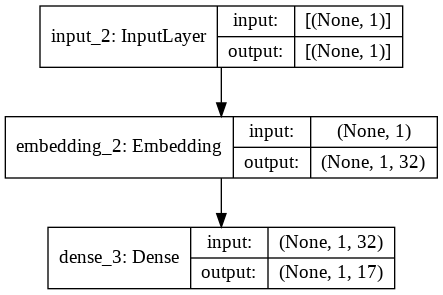

In [34]:
# 모델 생성
model, V = build_model(len(word_to_id), 32)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [35]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

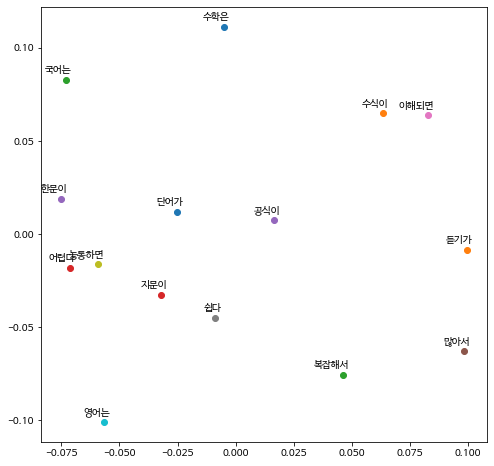

In [36]:
plot_embdeeding(V, word_to_id)

training >>> 100


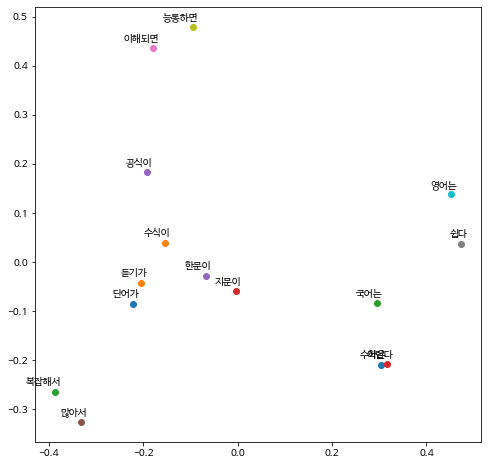

training >>> 200


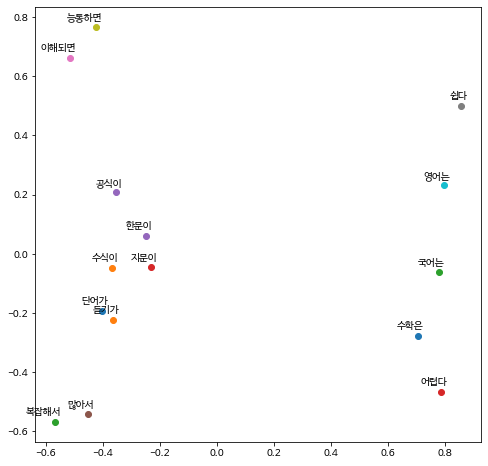

training >>> 300


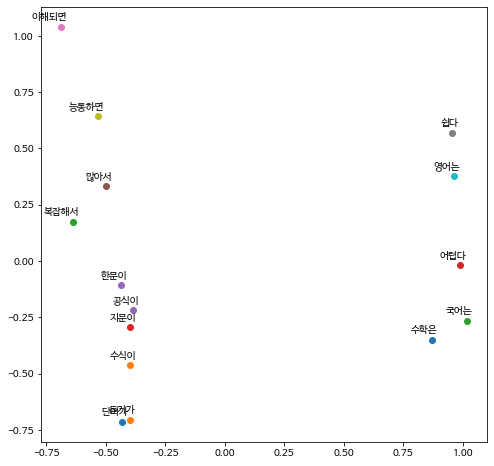

training >>> 400


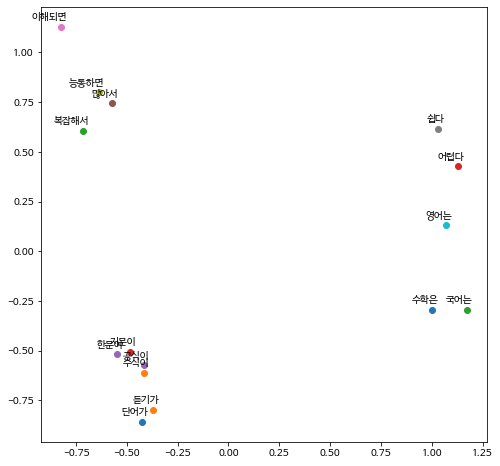

training >>> 500


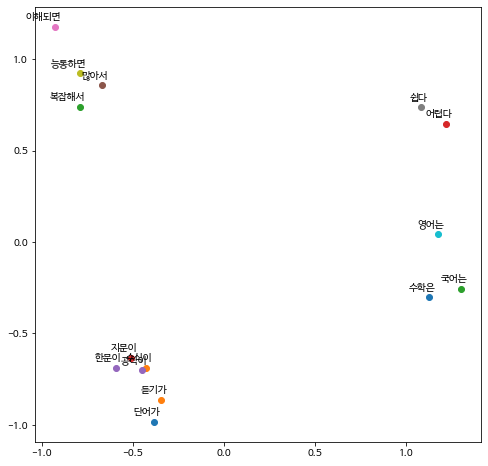

training >>> 600


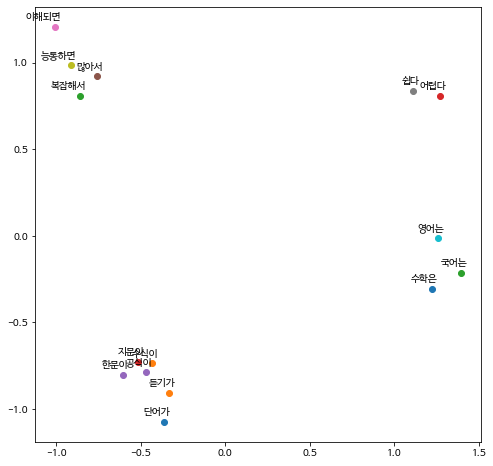

training >>> 700


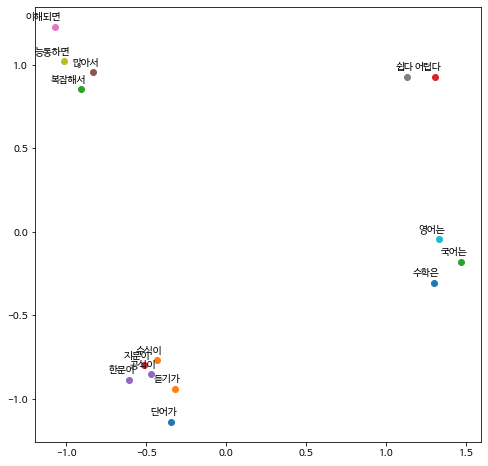

training >>> 800


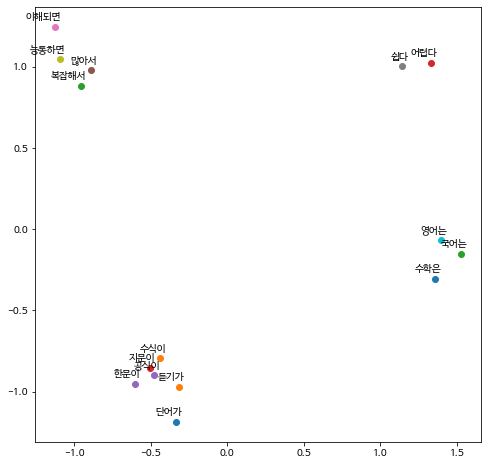

training >>> 900


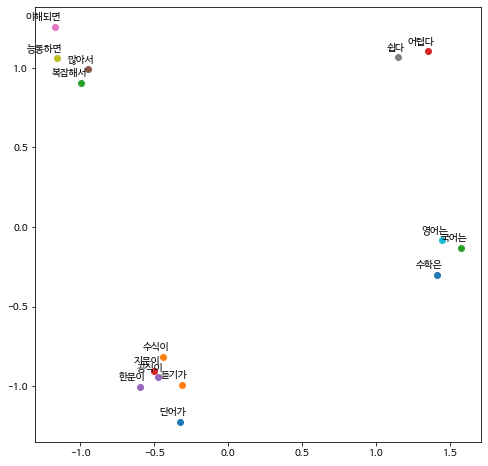

training >>> 1000


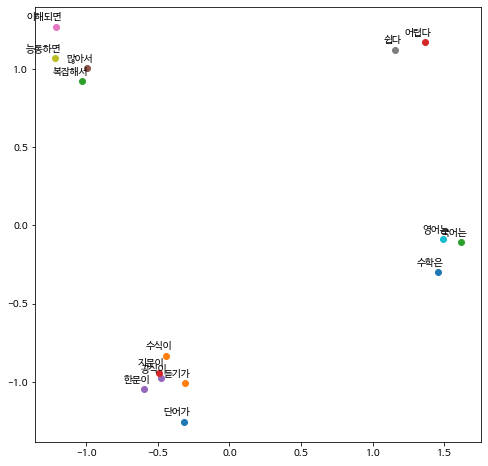

training >>> 1100


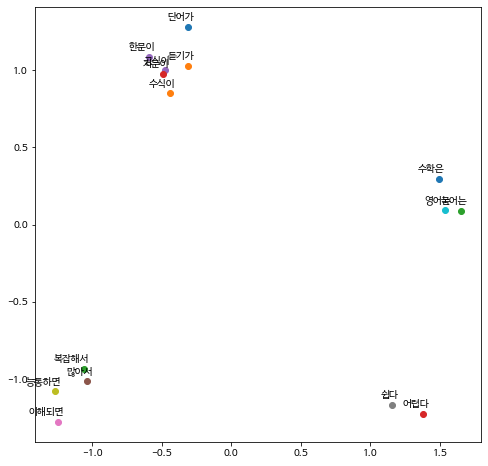

training >>> 1200


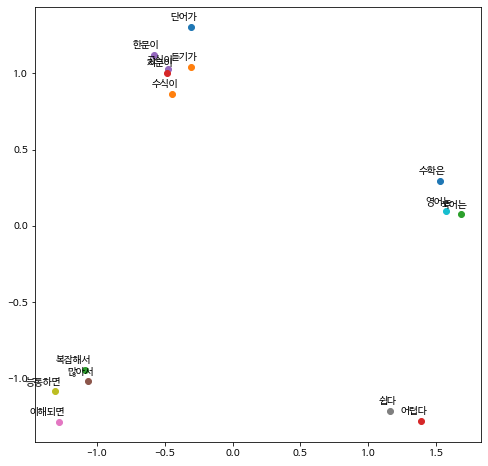

training >>> 1300


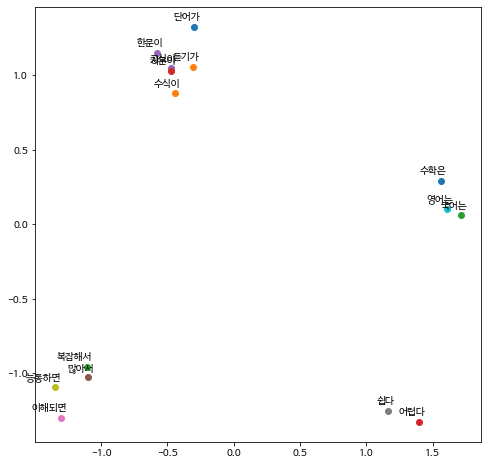

training >>> 1400


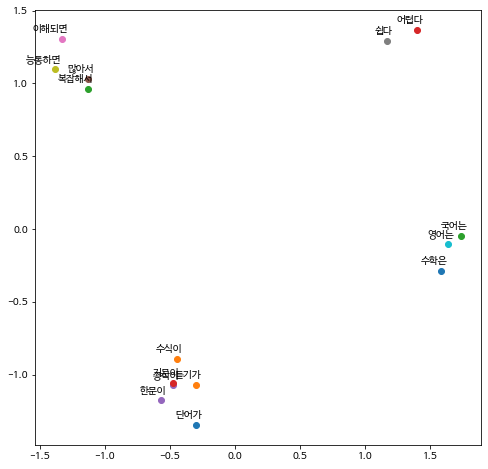

training >>> 1500


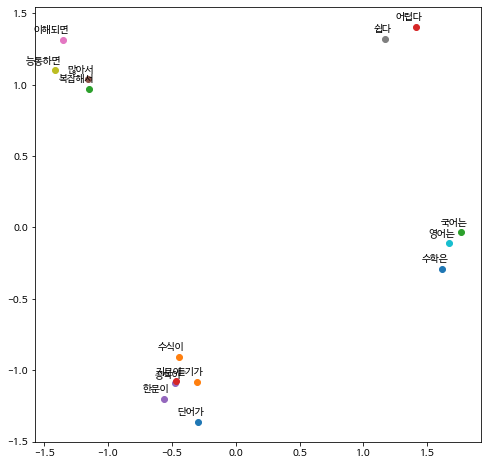

training >>> 1600


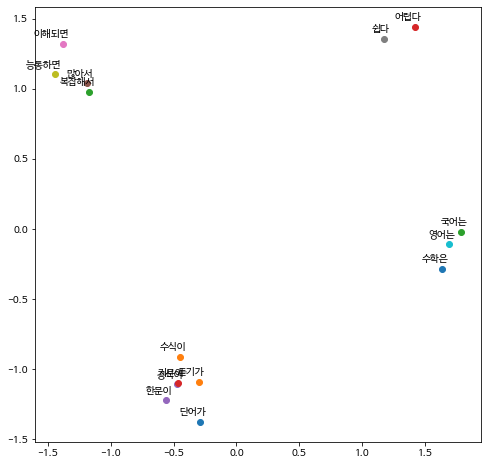

training >>> 1700


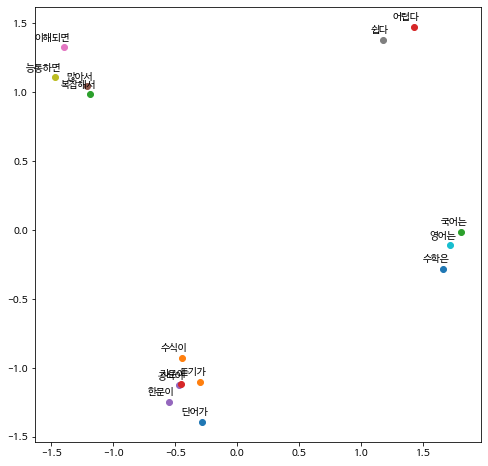

training >>> 1800


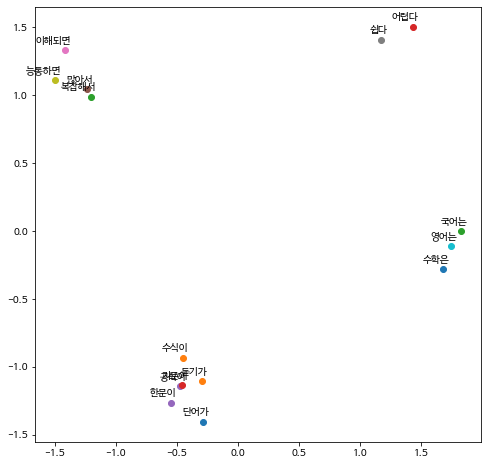

training >>> 1900


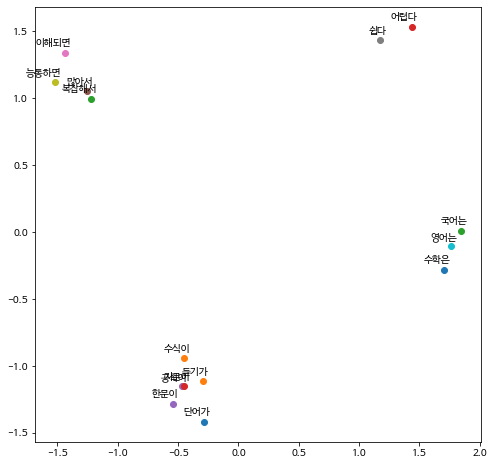

training >>> 2000


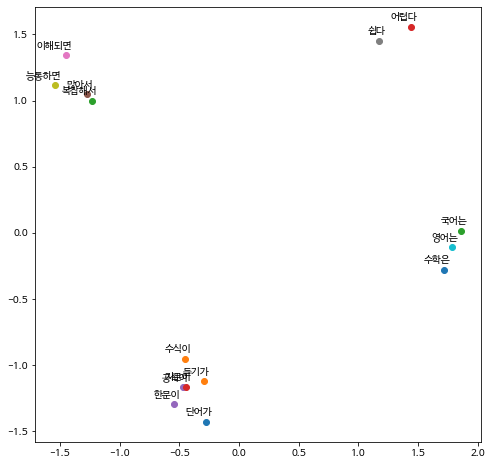

In [37]:
epochs = 100
# 20번 반복 진행
for i in range(20):
    # epoch 학습 진행 후 vector를 화면에 출력
    model.fit(train_token_ids, train_label_ids, batch_size=512, epochs=epochs, verbose=0)
    print(f"training >>> {(i+1) * epochs}")
    plot_embdeeding(V, word_to_id)

# Gensim
- https://radimrehurek.com/gensim/index.html

In [38]:
import gensim
import gensim.downloader as api

## Tutorial

In [39]:
# 이미 학습된 model download
# wv = api.load('word2vec-google-news-300') # 1.6G
wv = api.load('glove-wiki-gigaword-100') # 128M

In [40]:
# vocab 개수 및 최초 20개 출력
print(f"len: {len(wv.vocab)}")
for i, word in enumerate(wv.vocab):
    if i >= 20:
        break
    print(f"{i:2d}: {word}")

len: 400000
 0: the
 1: ,
 2: .
 3: of
 4: to
 5: and
 6: in
 7: a
 8: "
 9: 's
10: for
11: -
12: that
13: on
14: is
15: was
16: said
17: with
18: he
19: as


In [41]:
wv.most_similar('obama')

[('barack', 0.937216579914093),
 ('bush', 0.927285373210907),
 ('clinton', 0.8960003852844238),
 ('mccain', 0.8875633478164673),
 ('gore', 0.8000321388244629),
 ('hillary', 0.7933663129806519),
 ('dole', 0.7851964235305786),
 ('rodham', 0.751889705657959),
 ('romney', 0.7488929629325867),
 ('kerry', 0.7472623586654663)]

In [42]:
wv.most_similar('banana')

[('coconut', 0.7097253799438477),
 ('mango', 0.7054824233055115),
 ('bananas', 0.6887733936309814),
 ('potato', 0.6629636287689209),
 ('pineapple', 0.6534532904624939),
 ('fruit', 0.6519855260848999),
 ('peanut', 0.6420576572418213),
 ('pecan', 0.6349173188209534),
 ('cashew', 0.6294420957565308),
 ('papaya', 0.6246591210365295)]

In [43]:
wv.most_similar('apple')

[('microsoft', 0.7449405789375305),
 ('ibm', 0.6821643710136414),
 ('intel', 0.6778088212013245),
 ('software', 0.6775422096252441),
 ('dell', 0.6741442680358887),
 ('pc', 0.6678153276443481),
 ('macintosh', 0.66175377368927),
 ('iphone', 0.6595611572265625),
 ('ipod', 0.6534676551818848),
 ('hewlett', 0.6516579985618591)]

In [44]:
# king - man + woman by
result = wv.most_similar(positive=['woman', 'king'], negative=['man'])
result

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.6311717629432678),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [45]:
def analogy(p1, n1, p2):
    result = wv.most_similar(positive=[p2, p1], negative=[n1])
    return result

In [46]:
result = wv.most_similar(positive=['australia', 'japanese'], negative=['japan'])
result

[('australian', 0.8923498392105103),
 ('zealand', 0.8012940883636475),
 ('british', 0.7840811014175415),
 ('australians', 0.6766528487205505),
 ('indian', 0.6707968711853027),
 ('canadian', 0.6601305603981018),
 ('english', 0.639612078666687),
 ('england', 0.6350405216217041),
 ('sydney', 0.6257352232933044),
 ('britain', 0.6175568699836731)]

In [47]:
# japanese - japan + australia
analogy('japanese', 'japan', 'australia')

[('australian', 0.8923498392105103),
 ('zealand', 0.8012940883636475),
 ('british', 0.7840811014175415),
 ('australians', 0.6766528487205505),
 ('indian', 0.6707968711853027),
 ('canadian', 0.6601305603981018),
 ('english', 0.639612078666687),
 ('england', 0.6350405216217041),
 ('sydney', 0.6257352232933044),
 ('britain', 0.6175568699836731)]

In [48]:
# beer - australia + france
analogy('beer', 'australia', 'france')

[('champagne', 0.6480064988136292),
 ('wine', 0.6029773354530334),
 ('cognac', 0.599911093711853),
 ('drink', 0.596866250038147),
 ('perfume', 0.5843736529350281),
 ('drinks', 0.5787434577941895),
 ('vodka', 0.5771392583847046),
 ('beers', 0.5634331703186035),
 ('anheuser', 0.5613827705383301),
 ('bourbon', 0.552852988243103)]

In [49]:
# clinton - reagan + obama
analogy('clinton', 'reagan', 'obama')

[('barack', 0.8189094066619873),
 ('bush', 0.7976235151290894),
 ('mccain', 0.7815861701965332),
 ('gore', 0.7276442050933838),
 ('hillary', 0.7135353088378906),
 ('rodham', 0.6994726657867432),
 ('romney', 0.6853622198104858),
 ('dole', 0.6626838445663452),
 ('kerry', 0.6506499648094177),
 ('republicans', 0.6442651152610779)]

In [50]:
# tallest - tall + long
analogy('tallest', 'tall', 'long')

[('longest', 0.7037104964256287),
 ('the', 0.6229448914527893),
 ('major', 0.6216300129890442),
 ('time', 0.6173369884490967),
 ('first', 0.616451621055603),
 ('since', 0.60569828748703),
 ('decade', 0.6019695997238159),
 ('busiest', 0.600587785243988),
 ('its', 0.6004385352134705),
 ('part', 0.60023432970047)]

In [51]:
# fantastic - good + bad
analogy('fantastic', 'good', 'bad')

[('terrible', 0.7074226140975952),
 ('awful', 0.70609450340271),
 ('horrible', 0.6906466484069824),
 ('scary', 0.6802915334701538),
 ('weird', 0.6775556206703186),
 ('crazy', 0.6615543365478516),
 ('strange', 0.6522735953330994),
 ('dreadful', 0.6404813528060913),
 ('bizarre', 0.6389496922492981),
 ('incredible', 0.6321425437927246)]

In [52]:
wv.doesnt_match("breakfast cereal dinner lunch".split())

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'cereal'

In [53]:
def display_pca_scatterplot(model, words=None, n_sample=100):
    if not words:
        words = np.random.choice(list(model.vocab.keys()), n_sample)
    word_vectors = np.array([model[w] for w in words])

    # 폰트
    font_name = "NanumBarunGothic"

    # plot 크기 및 폰트 설정
    plt.rc('font', family=font_name)
    plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결

    word_vectors = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(12,12))
    plt.scatter(word_vectors[:,0], word_vectors[:,1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, word_vectors):
        plt.text(x, y, word)
    plt.show()

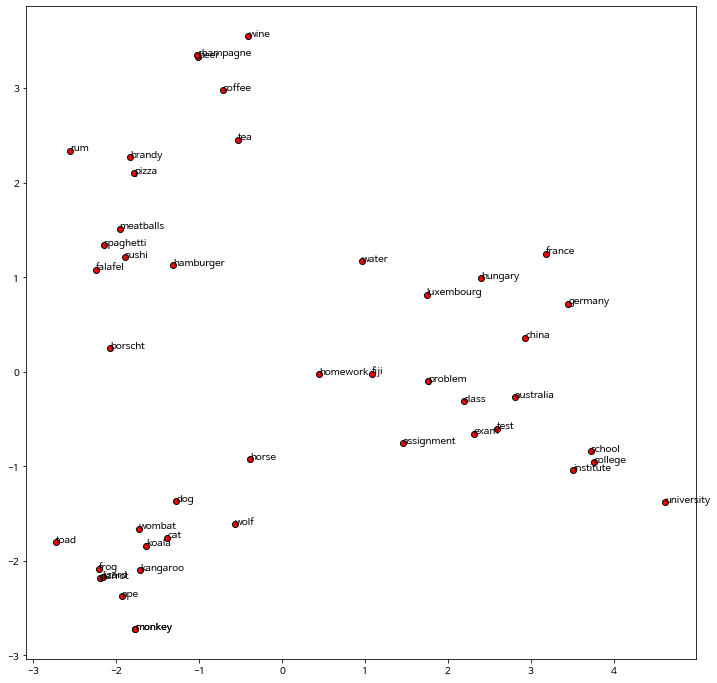

In [54]:
display_pca_scatterplot(wv, words=['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 234 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 229 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 257 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 233 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 234 missing from current font.
  font.set_text(s, 0, fla

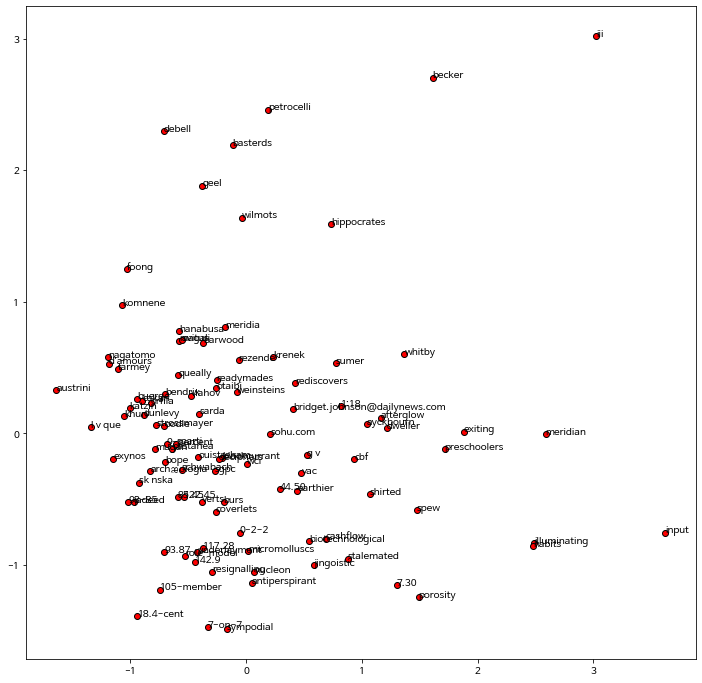

In [55]:
display_pca_scatterplot(wv)